In [166]:
# pip install
#!pip install -r requirements.txt

# Imports
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
from pprint import pprint
import time

# Module imports
from periodic_table import *
from utils import *
print("Imported all.")

Imported all.


# Open data files

In [167]:
# original, NC, FTFP
physic_model = "NC"

# Open propmt TPC data file
file_dir = f"./assets/{physic_model}/A_Z_count-TPC_prompt.txt"
columns = ["Mass Number", "Atomic Number", "Counts"]
df_TPC_prompt = open_data(file_dir, columns)
# Add in isotope data
add_isotope_data(df_TPC_prompt)
# Reorder columns
df_TPC_prompt = df_TPC_prompt[["Iso Symbol","Atomic Number","Mass Number","Counts","Production Yield","Stable","Half Life (ns)","Decay Modes (m, b, q MeV)","Max Q-Value","Plot Colour",]]

Considered delayed if created at time > 20 microseconds

In [168]:
# Open delayed TPC data file
file_dir = f"./assets/{physic_model}/A_Z_count-TPC_delayed.txt"
columns = ["Mass Number", "Atomic Number", "Counts"]
df_TPC_delayed = open_data(file_dir, columns)
# Add in isotope data
add_isotope_data(df_TPC_delayed)
# Reorder columns
df_TPC_delayed = df_TPC_delayed[["Iso Symbol","Atomic Number","Mass Number","Counts","Production Yield","Stable","Half Life (ns)","Decay Modes (m, b, q MeV)","Max Q-Value","Plot Colour",]]

In [169]:
# Open buffer data file
file_dir = f"./assets/{physic_model}/A_Z_count-buffers.txt"
columns = ["Mass Number", "Atomic Number", "Counts"]
df_buffers = open_data(file_dir, columns)
# Add in isotope data
add_isotope_data(df_buffers)
# Reorder columns
df_buffers = df_buffers[["Iso Symbol","Atomic Number","Mass Number","Counts","Production Yield","Stable","Half Life (ns)","Decay Modes (m, b, q MeV)","Max Q-Value","Plot Colour",]]

# Preprocessing

### Add Production (/yr)

In [170]:
# Simulation length = years * nanoseconds
year_in_nano = (3.154 * 10**16)
year_in_sec = (3.154 * 10**7)
day_in_nano = (8.64 * 10 ** 13)
### VARY THIS ###
muon_no = 10 ** 8
muon_flux = 3.447 * 10 ** 6 # per year
sim_length = muon_no / muon_flux
print(f"Simulation length (yr): {sim_length}")

df_buffers["Production (/yr)"] = df_buffers["Counts"] / sim_length
df_TPC_prompt["Production (/yr)"] = df_TPC_prompt["Counts"] / sim_length
df_TPC_delayed["Production (/yr)"] = df_TPC_delayed["Counts"] / sim_length
# Yield per muon
df_buffers["Yield per Muon (/yr)"] = df_buffers["Counts"] / muon_no
df_TPC_prompt["Yield per Muon (/yr)"] = df_TPC_prompt["Counts"] / muon_no
df_TPC_delayed["Yield per Muon (/yr)"] = df_TPC_delayed["Counts"] / muon_no

Simulation length (yr): 29.01073397156948


### Create unstable dfs

In [171]:
unstable_buffers = df_buffers[df_buffers["Stable"] == False]
unstable_TPC_prompt = df_TPC_prompt[df_TPC_prompt["Stable"] == False]
unstable_TPC_delayed = df_TPC_delayed[df_TPC_delayed["Stable"] == False]

### Print Information

In [172]:
print("Buffers:")
print(f"No: {len(df_buffers)}")
print(f"Total Counts: {df_buffers['Counts'].sum()}")
print(f"Total Production (yr): {df_buffers['Production (/yr)'].sum()}")
print(f"Number of stable isotopes: {len(df_buffers) - len(unstable_buffers)}")
print(f"Number of unstable isotopes: {len(unstable_buffers)}")
print()
print("TPC Prompt:")
print(f"No: {len(df_TPC_prompt)}")
print(f"Total Counts: {df_TPC_prompt['Counts'].sum()}")
print(f"Total Production (yr): {df_TPC_prompt['Production (/yr)'].sum()}")
print(f"Number of stable isotopes: {len(df_TPC_prompt) - len(unstable_TPC_prompt)}")
print(f"Number of unstable isotopes: {len(unstable_TPC_prompt)}")
print()
print("TPC Delayed:")
print(f"No: {len(df_TPC_delayed)}")
print(f"Total Counts: {df_TPC_delayed['Counts'].sum()}")
print(f"Total Production (yr): {df_TPC_delayed['Production (/yr)'].sum()}")
print(f"Number of stable isotopes: {len(df_TPC_delayed) - len(unstable_TPC_delayed)}")
print(f"Number of unstable isotopes: {len(unstable_TPC_delayed)}")

Buffers:
No: 181
Total Counts: 191335006
Total Production (yr): 6595317.656820001
Number of stable isotopes: 39
Number of unstable isotopes: 142

TPC Prompt:
No: 170
Total Counts: 79525683
Total Production (yr): 2741250.293009999
Number of stable isotopes: 39
Number of unstable isotopes: 131

TPC Delayed:
No: 93
Total Counts: 18009353
Total Production (yr): 620782.39791
Number of stable isotopes: 39
Number of unstable isotopes: 54


### Filter by realistic half-life

Find max and min half lifes

In [173]:
print("Buffers:")
print(f"Min half life (nano): {unstable_buffers['Half Life (ns)'].min()}\nMax half life (day): {unstable_buffers['Half Life (ns)'].max() / day_in_nano}")
print("TPC Prompt:")
print(f"Min half life (nano): {unstable_TPC_prompt['Half Life (ns)'].min()}\nMax half life (day): {unstable_TPC_prompt['Half Life (ns)'].max() / day_in_nano}")
print("TPC Delayed:")
print(f"Min half life (nano): {unstable_TPC_delayed['Half Life (ns)'].min()}\nMax half life (day): {unstable_TPC_delayed['Half Life (ns)'].max() / day_in_nano}")

Buffers:
Min half life (nano): 0.0
Max half life (day): 1096064814814814.9
TPC Prompt:
Min half life (nano): 0.0
Max half life (day): 1096064814814814.9
TPC Delayed:
Min half life (nano): 7.91e-22
Max half life (day): 1096064814814814.9


In [174]:
# year * days * nanoseconds
upper_lim = 1 * 356 * day_in_nano
buffer_before = len(unstable_buffers)
TPC_p_before = len(unstable_TPC_prompt)
TPC_d_before = len(unstable_TPC_delayed)
unstable_buffers = unstable_buffers[unstable_buffers["Half Life (ns)"] < upper_lim].sort_values("Half Life (ns)")
unstable_TPC_prompt = unstable_TPC_prompt[unstable_TPC_prompt["Half Life (ns)"] < upper_lim].sort_values("Half Life (ns)")
unstable_TPC_delayed = unstable_TPC_delayed[unstable_TPC_delayed["Half Life (ns)"] < upper_lim].sort_values("Half Life (ns)")
print(f"Difference:")
print(f"Buffers: {buffer_before - len(unstable_buffers)}")
print(f"TPC Prompt: {TPC_p_before - len(unstable_TPC_prompt)}")
print(f"TPC Delayed: {TPC_d_before - len(unstable_TPC_delayed)}")

Difference:
Buffers: 2
TPC Prompt: 3
TPC Delayed: 1


### Add beta decay energy columns

In [175]:
# https://nds.iaea.org/relnsd/vcharthtml/api_v0_notebook.html
# https://nds.iaea.org/relnsd/vcharthtml/api_v0_guide.html#gamma
# https://nds.iaea.org/relnsd/vcharthtml/VChartHTML.html
#!pip install plotly
import plotly.express as px
import plotly.graph_objects as go
import time

# the service URL
livechart = "https://nds.iaea.org/relnsd/v0/data?"

import urllib.request

def lc_read_csv(url):
    req = urllib.request.Request(url)
    req.add_header('User-Agent', 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:77.0) Gecko/20100101 Firefox/77.0')
    return pd.read_csv(urllib.request.urlopen(req))

def gamma_dec(iso_sym):
    """Calculates average gamma decay - depreciated"""
    sym = iso_sym.split(" ")[0].lower()
    A = iso_sym.split(" ")[1].split("-")[1]
    df = lc_read_csv(livechart + f"fields=decay_rads&nuclides={str(A)+sym}&rad_types=g")
    if not df.empty:
        try:
            average = (df["energy"] * df["intensity"]/100).sum()
            return average
        except:
            pass
    return None

def g_in_range(iso_sym, min_e, max_e, found_e_range, rad_type):
    "Returns True if gamma found in range else False"
    if rad_type == "bm":
        energy_title = "mean_energy"
    else:
        energy_title = "energy"
    sym = iso_sym.split(" ")[0].lower()
    A = iso_sym.split(" ")[1].split("-")[1]
    df = lc_read_csv(livechart + f"fields=decay_rads&nuclides={str(A)+sym}&rad_types={rad_type}")
    ### IMPORTANT ###
    threshhold_intensity = 0.5
    time.sleep(0.02)
    if not df.empty:
        try:
            df = df[df["intensity_beta"] > threshhold_intensity]
            if df[energy_title].max() > found_e_range[1]:
                found_e_range[1] = df[energy_title].max()
            if df[energy_title].min() < found_e_range[0]:
                found_e_range[0] = df[energy_title].min()
            if df[energy_title].between(min_e,max_e).any():
                return True
        except:
            return np.nan
    return False

Get specific data

In [176]:
A = 41
sym = "ar"
# a bp bm g e x (α, β-, β+ and electron capture, γ, Auger and conversion electron, X-ray)
df = lc_read_csv(livechart + f"fields=decay_rads&nuclides={str(A)+sym}&rad_types=bm")
# df

Add decay columns

In [177]:
min_b_e = 0
max_b_e = 100
found_e_range = [np.inf,0]
rad_type = "bm"
beta_col_name = f"BDecay {min_b_e}-{max_b_e} (keV)"
unstable_TPC_delayed[beta_col_name] = unstable_TPC_delayed.apply(lambda x : g_in_range(x["Iso Symbol"], min_b_e, max_b_e, found_e_range, rad_type), axis = 1)
unstable_TPC_prompt[beta_col_name] = unstable_TPC_prompt.apply(lambda x : g_in_range(x["Iso Symbol"], min_b_e, max_b_e, found_e_range, rad_type), axis = 1)
unstable_buffers[beta_col_name] = unstable_buffers.apply(lambda x : g_in_range(x["Iso Symbol"], min_b_e, max_b_e, found_e_range, rad_type), axis = 1)
print(f"Decay beta energy range (min/max) {found_e_range[0]}-{found_e_range[1]} keV")

Decay beta energy range (min/max) 48.758-10048 keV


# Total ratios of prompt to delayed counts

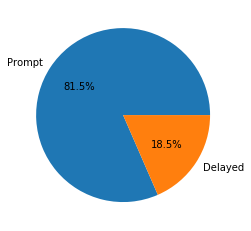

In [178]:
plt.pie(x=[df_TPC_prompt["Counts"].sum(), df_TPC_delayed["Counts"].sum()], autopct='%1.1f%%', labels=["Prompt", "Delayed"])
plt.savefig('./img/prompt-delayed.png')
plt.show()

# Total ratio of counts in TPC to buffer 

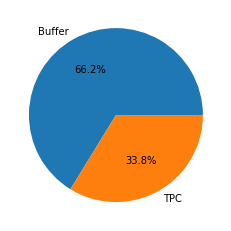

In [179]:
plt.pie(x=[df_buffers["Counts"].sum(), df_TPC_delayed["Counts"].sum() + df_TPC_prompt["Counts"].sum()], autopct='%1.1f%%', labels=["Buffer", "TPC"])
plt.show()

# Look for important unstable in buffer
Can't really do this - need another geant4 simulation

# Look for important unstable prompt isotopes in TPC
Isotopes that are produced inside the deadtime, but will live long enough to decay outside this time and emit a detectable signal

In [180]:
unstable_TPC_prompt.sort_values("Atomic Number", ascending=False).head(30)

,Iso Symbol,Atomic Number,Mass Number,Counts,Production Yield,Stable,Half Life (ns),"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour,Production (/yr),Yield per Muon (/yr),BDecay 0-100 (keV)
154,Ca 20-39,20,39,1,1.257455e-08,False,8.600000e-01,"[[EC, 1.0, 6.533]]",6.533,red,0.03447,1e-08,False
162,Ca 20-41,20,41,6,7.544732e-08,False,3.220000e+12,"[[EC, 1.0, 0.421]]",0.421,red,0.20682,6e-08,False
164,K 19-42,19,42,41,5.155567e-07,False,4.440000e+04,"[[B-, 1.0, 3.526]]",3.526,red,1.41327,4.1e-07,False
148,K 19-38,19,38,180,2.263420e-06,False,4.580000e+02,"[[EC, 1.0, 5.914]]",5.914,red,6.2046,1.8e-06,False
137,K 19-36,19,36,3,3.772366e-08,False,3.420000e-01,"[[EC, 1.0, 12.805], [EP, 0.0005, 4.298], [EA, ...",12.805,red,0.10341,3e-08,False
166,K 19-43,19,43,1,1.257455e-08,False,8.030000e+04,"[[B-, 1.0, 1.815]]",1.815,red,0.03447,1e-08,False
143,K 19-37,19,37,5,6.287277e-08,False,1.230000e+00,"[[EC, 1.0, 6.147]]",6.147,red,0.17235,5e-08,False
131,Ar 18-35,18,35,515,6.475895e-06,False,1.780000e+00,"[[EC, 1.0, 5.966]]",5.966,red,17.7521,5.15e-06,False
160,Ar 18-41,18,41,95890,1.205774e-03,False,6.580000e+03,"[[B-, 1.0, 2.492]]",2.492,red,3305.33,0.0009589,False
142,Ar 18-37,18,37,92041,1.157375e-03,False,3.030000e+06,"[[EC, 1.0, 0.814]]",0.814,red,3172.65,0.00092041,False


In [181]:
# Filter with halflife greater than deadtime (lasts long enough)
important_TPC_prompt = unstable_TPC_prompt[unstable_TPC_prompt["Half Life (ns)"] > 20000000].sort_values("Production (/yr)", ascending=False).reset_index(drop=True)
# Filter with beta energy ranges
important_TPC_prompt = important_TPC_prompt[pd.isnull(important_TPC_prompt[beta_col_name]) | (important_TPC_prompt[beta_col_name] == True)]

print(f"Number of isotopes in range: {len(important_TPC_prompt)}")
print(f"Total Production (/yr): {important_TPC_prompt['Production (/yr)'].sum()}")
important_TPC_prompt

Number of isotopes in range: 2
Total Production (/yr): 181.6569


,Iso Symbol,Atomic Number,Mass Number,Counts,Production Yield,Stable,Half Life (ns),"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour,Production (/yr),Yield per Muon (/yr),BDecay 0-100 (keV)
2,Si 14-32,14,32,4824,0.000061,False,4.830000e+09,"[[B-, 1.0, 0.224]]",0.224,red,166.283,4.824e-05,True
5,C 6-14,6,14,446,0.000006,False,1.800000e+11,"[[B-, 1.0, 0.156]]",0.156,red,15.3736,4.46e-06,True


# Look for important unstable delayed isotopes in TPC

## Any isotopes that beta decay

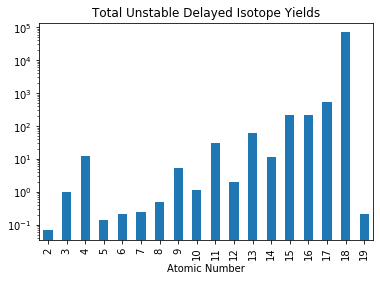

,Iso Symbol,Atomic Number,Mass Number,Counts,Production Yield,Stable,Half Life (ns),"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour,Production (/yr),Yield per Muon (/yr),BDecay 0-100 (keV)
0,Ar 18-41,18,41,1793830,9.960547e-02,False,6.580000e+03,"[[B-, 1.0, 2.492]]",2.492,red,61833.3,0.0179383,False
1,Ar 18-39,18,39,168935,9.380404e-03,False,8.490000e+09,"[[B-, 1.0, 0.565]]",0.565,red,5823.19,0.00168935,False
2,Ar 18-37,18,37,48543,2.695433e-03,False,3.030000e+06,"[[EC, 1.0, 0.814]]",0.814,red,1673.28,0.00048543,False
3,Cl 17-38,17,38,15151,8.412851e-04,False,2.230000e+03,"[[B-, 1.0, 4.916]]",4.916,red,522.255,0.00015151,False
4,S 16-35,16,35,5185,2.879060e-04,False,7.550000e+06,"[[B-, 1.0, 0.167]]",0.167,red,178.727,5.185e-05,True
5,P 15-32,15,32,4849,2.692490e-04,False,1.230000e+06,"[[B-, 1.0, 1.71]]",1.710,red,167.145,4.849e-05,False
6,Al 13-28,13,28,1534,8.517796e-05,False,1.340000e+02,"[[B-, 1.0, 4.642]]",4.642,red,52.877,1.534e-05,False
7,S 16-37,16,37,963,5.347222e-05,False,3.030000e+02,"[[B-, 1.0, 4.865]]",4.865,red,33.1946,9.63e-06,False
8,Na 11-24,11,24,773,4.292214e-05,False,5.400000e+04,"[[B-, 1.0, 5.515]]",5.515,red,26.6453,7.73e-06,False
9,P 15-34,15,34,617,3.425998e-05,False,1.240000e+01,"[[B-, 1.0, 5.374]]",5.374,red,21.268,6.17e-06,False


In [182]:
# All unstable that beta decay with decays per year > 1
unstable_TPC_delayed_beta = unstable_TPC_delayed.sort_values("Counts", ascending=False).reset_index(drop=True)
unstable_TPC_delayed_grouped = unstable_TPC_delayed_beta.groupby(['Atomic Number'])["Production (/yr)"].sum()
unstable_TPC_delayed_grouped.plot.bar(x="Atomic Number", log=True)
plt.title("Total Unstable Delayed Isotope Yields")
plt.show()
unstable_TPC_delayed_beta.head(70)

## Filter with high probability for beta emission in range

In [183]:
# Filter with beta energy ranges
important_TPC_delayed = unstable_TPC_delayed[pd.isnull(unstable_TPC_delayed[beta_col_name]) | (unstable_TPC_delayed[beta_col_name] == True)].sort_values("Counts", ascending=False).reset_index(drop=True)

print(f"Number of isotopes in range: {len(important_TPC_delayed)}")
print(f"Total Production (yr): {important_TPC_delayed['Production (/yr)'].sum()}\n")

print(f"Beta decays: {len(important_TPC_delayed[important_TPC_delayed[beta_col_name] == True])}")
print(f"Beta decay productions (/yr): {important_TPC_delayed.loc[important_TPC_delayed[beta_col_name] == True, 'Production (/yr)'].sum()}\n")

Number of isotopes in range: 7
Total Production (yr): 206.71659

Beta decays: 6
Beta decay productions (/yr): 206.50977



In [184]:
file_dir = f"./assets/{physic_model}/important_iso.csv"
important_TPC_delayed.to_csv(file_dir)
important_TPC_delayed

,Iso Symbol,Atomic Number,Mass Number,Counts,Production Yield,Stable,Half Life (ns),"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour,Production (/yr),Yield per Muon (/yr),BDecay 0-100 (keV)
0,S 16-35,16,35,5185,2.879060e-04,False,7.550000e+06,"[[B-, 1.0, 0.167]]",0.167,red,178.727,5.185e-05,True
1,P 15-33,15,33,606,3.364918e-05,False,2.190000e+06,"[[B-, 1.0, 0.249]]",0.249,red,20.8888,6.06e-06,True
2,S 16-38,16,38,157,8.717692e-06,False,1.020000e+04,"[[B-, 1.0, 2.937]]",2.937,red,5.41179,1.57e-06,True
3,Si 14-32,14,32,36,1.998961e-06,False,4.830000e+09,"[[B-, 1.0, 0.224]]",0.224,red,1.24092,3.6e-07,True
4,Si 14-34,14,34,6,3.331602e-07,False,2.770000e+00,"[[B-, 1.0, 4.601]]",4.601,red,0.20682,6e-08,NaN
5,C 6-14,6,14,6,3.331602e-07,False,1.800000e+11,"[[B-, 1.0, 0.156]]",0.156,red,0.20682,6e-08,True
6,Mg 12-28,12,28,1,5.552670e-08,False,7.530000e+04,"[[B-, 1.0, 1.832]]",1.832,red,0.03447,1e-08,True


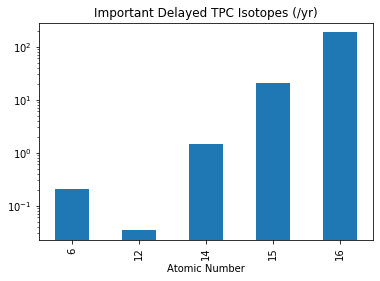

In [185]:
important_TPC_delayed_groups = important_TPC_delayed.groupby(['Atomic Number'])["Production (/yr)"].sum()
important_TPC_delayed_groups.plot.bar(x="Atomic Number", log=True)
plt.title("Important Delayed TPC Isotopes (/yr)")
plt.show()

# Combine df and convert to latex

In [186]:
print("Table Splitting (inclusive)")
important_combined = pd.concat([important_TPC_prompt.sort_values("Counts", ascending=False), important_TPC_delayed.sort_values("Counts", ascending=False), unstable_TPC_delayed_beta.sort_values("Counts", ascending=False)]).reset_index(drop=True)
print(f"Total: {len(important_combined)}")
print(f"TPC Prompt: 0-{len(important_TPC_prompt)-1}")
print(f"TPC Delayed: {len(important_TPC_prompt)}-{len(important_TPC_prompt) + len(important_TPC_delayed)-1}")
print("Rest is all unstable in detector")
important_combined

Table Splitting (inclusive)
Total: 62
TPC Prompt: 0-1
TPC Delayed: 2-8
Rest is all unstable in detector


,Iso Symbol,Atomic Number,Mass Number,Counts,Production Yield,Stable,Half Life (ns),"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour,Production (/yr),Yield per Muon (/yr),BDecay 0-100 (keV)
0,Si 14-32,14,32,4824,6.065965e-05,False,4.830000e+09,"[[B-, 1.0, 0.224]]",0.224,red,166.283,4.824e-05,True
1,C 6-14,6,14,446,5.608251e-06,False,1.800000e+11,"[[B-, 1.0, 0.156]]",0.156,red,15.3736,4.46e-06,True
2,S 16-35,16,35,5185,2.879060e-04,False,7.550000e+06,"[[B-, 1.0, 0.167]]",0.167,red,178.727,5.185e-05,True
3,P 15-33,15,33,606,3.364918e-05,False,2.190000e+06,"[[B-, 1.0, 0.249]]",0.249,red,20.8888,6.06e-06,True
4,S 16-38,16,38,157,8.717692e-06,False,1.020000e+04,"[[B-, 1.0, 2.937]]",2.937,red,5.41179,1.57e-06,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,N 7-17,7,17,2,1.110534e-07,False,4.170000e+00,"[[B-, 1.0, 8.68], [BN, 0.951, 4.537]]",8.680,red,0.06894,2e-08,False
58,He 2-5,2,5,2,1.110534e-07,False,7.910000e-22,"[[A, 1.0, 0.89], [N, 1.0, 0.89]]",0.890,red,0.06894,2e-08,False
59,Mg 12-28,12,28,1,5.552670e-08,False,7.530000e+04,"[[B-, 1.0, 1.832]]",1.832,red,0.03447,1e-08,True
60,S 16-39,16,39,1,5.552670e-08,False,1.150000e+01,"[[B-, 1.0, 6.638]]",6.638,red,0.03447,1e-08,False


In [187]:
# Add columns
important_combined["Half Life (s)"] = important_combined["Half Life (ns)"] * 10 ** -9

In [188]:
important_combined = important_combined[["Iso Symbol", "Production (/yr)", "Yield per Muon (/yr)", "Half Life (ns)", "Decay Modes (m, b, q MeV)"]]
print("\n", important_combined.to_latex())


 \begin{tabular}{llllrl}
\toprule
{} & Iso Symbol & Production (/yr) & Yield per Muon (/yr) &  Half Life (ns) &                          Decay Modes (m, b, q MeV) \\
\midrule
0  &   Si 14-32 &          166.283 &            4.824e-05 &    4.830000e+09 &                                 [[B-, 1.0, 0.224]] \\
1  &     C 6-14 &          15.3736 &             4.46e-06 &    1.800000e+11 &                                 [[B-, 1.0, 0.156]] \\
2  &    S 16-35 &          178.727 &            5.185e-05 &    7.550000e+06 &                                 [[B-, 1.0, 0.167]] \\
3  &    P 15-33 &          20.8888 &             6.06e-06 &    2.190000e+06 &                                 [[B-, 1.0, 0.249]] \\
4  &    S 16-38 &          5.41179 &             1.57e-06 &    1.020000e+04 &                                 [[B-, 1.0, 2.937]] \\
5  &   Si 14-32 &          1.24092 &              3.6e-07 &    4.830000e+09 &                                 [[B-, 1.0, 0.224]] \\
6  &   Si 14-34 &          0.206